In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve,precision_score,recall_score,auc,accuracy_score
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance
from tabulate import tabulate

import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv('/content/price_optimsation_dataset.csv')

In [3]:
df.shape

(676, 30)

## 676 rows and 30 columns

In [4]:
df.isna().sum().sum()

0

## No missing values

In [5]:
df[df.duplicated()].shape

(0, 30)

## No duplicated values

In [6]:
pd.set_option('display.max_columns', None)
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,350,4.0,90,23,8,1,8,2017,9.293873,3800,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,350,4.0,54,21,9,1,9,2017,5.555556,3800,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [7]:
set1=['qty','total_price', 'freight_price', 'unit_price', 'product_photos_qty', 'product_weight_g',
       'product_score']

set2=['product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume']

set3=['comp_1', 'ps1', 'fp1', 'lag_price', 'total_price', 'qty']

set4=['comp_2', 'ps2', 'fp2', 'lag_price', 'total_price', 'qty']

set5=['comp_3', 'ps3', 'fp3', 'lag_price', 'total_price', 'qty']

## Outlier clipping

In [8]:
### Used 2.7 std around the  mean as cutoff for clipping numerical columns

def outlier_clipping(df,set):
    for col in set:
        m,s=np.mean(df[col]),np.std(df[col],ddof=1)
        max_,min_=m+(2.7)*s,m-(2.7)*s
        df[col]=np.clip(df[col],min_,max_)

for set in [set1, set2, set3, set4, set5]:
    outlier_clipping(df,set)

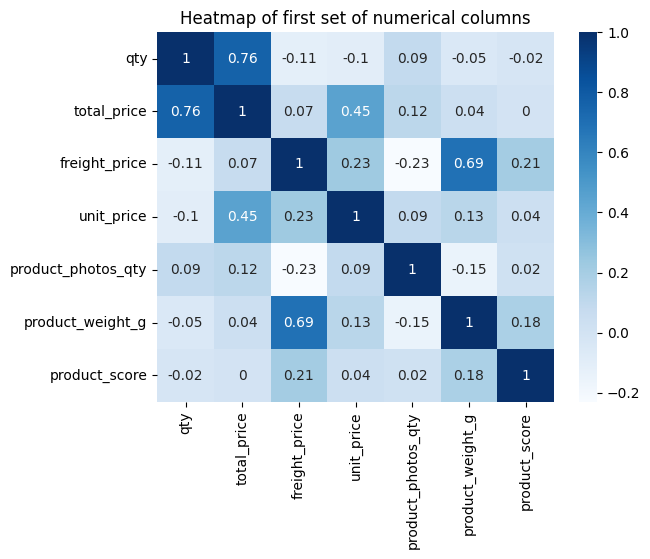

In [9]:
sns.heatmap(df[set1].corr().round(2),annot=True,cmap='Blues')
plt.title('Heatmap of first set of numerical columns')
plt.show()

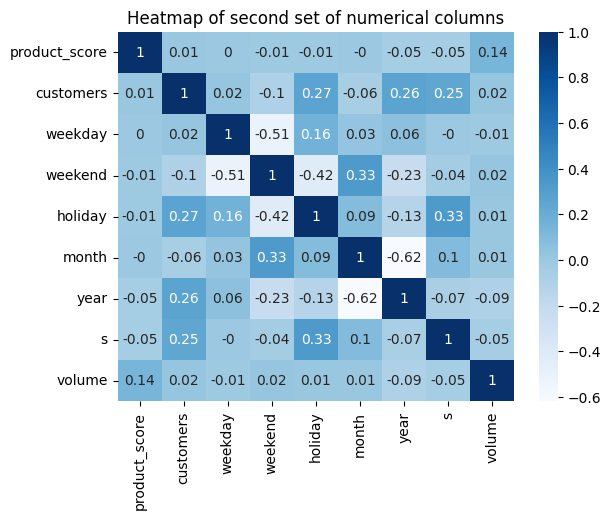

In [10]:
sns.heatmap(df[set2].corr().round(2),annot=True,cmap='Blues')
plt.title('Heatmap of second set of numerical columns')
plt.show()

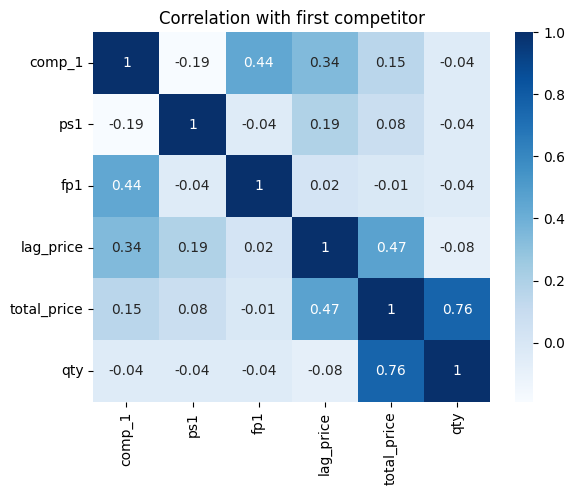

In [11]:
sns.heatmap(df[set3].corr().round(2),annot=True,cmap='Blues')
plt.title('Correlation with first competitor')
plt.show()

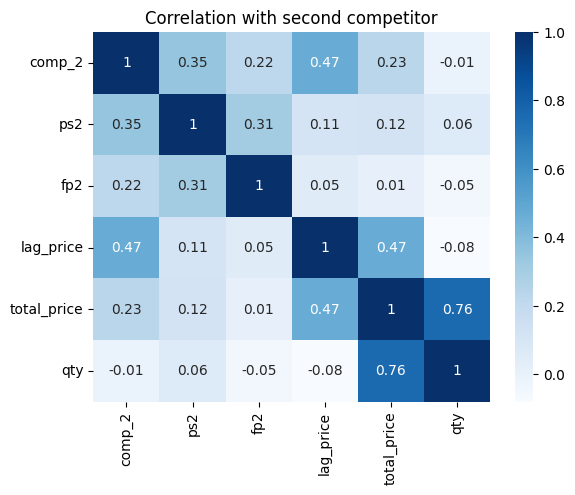

In [12]:
sns.heatmap(df[set4].corr().round(2),annot=True,cmap='Blues')
plt.title('Correlation with second competitor')
plt.show()

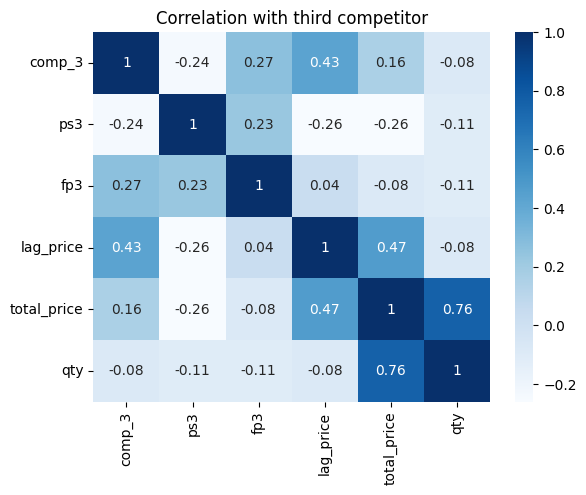

In [13]:
sns.heatmap(df[set5].corr().round(2),annot=True,cmap='Blues')
plt.title('Correlation with third competitor')
plt.show()

### Freight price is positively correlated with weight, total price is positively correlated with quantity, weekday and weekend are negatively correlated. These are quite self explanatory.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    float64
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    float64
 10  product_weight_g            676 non-null    float64
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    float64
 13  weekday                     676 non

## Feature Engineering

In [15]:
df['Revenue']=df.total_price-df.freight_price

w1=df.comp_1.corr(df.lag_price)
w2=df.comp_2.corr(df.lag_price)
w3=df.comp_3.corr(df.lag_price)
#comp price is weighted mean with correlation of lag_price with respective competitive price
df['comp']=(df.comp_1*w1+df.comp_2*w2+df.comp_3*w3)/(w1+w2+w3)
df['comp_ps']=(df.ps1*w1+df.ps2*w2+df.ps3*w3)/(w1+w2+w3)
df['comp_fp']=(df.fp1*w1+df.fp2*w2+df.fp3*w3)/(w1+w2+w3)
df=df.drop(columns=['unit_price','product_name_lenght','product_description_lenght','comp_1','comp_2','comp_3','ps1','ps2','ps3','fp1','fp2','fp3'])

In [16]:
df.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'product_photos_qty',
       'product_weight_g', 'product_score', 'customers', 'weekday', 'weekend',
       'holiday', 'month', 'year', 's', 'volume', 'lag_price', 'Revenue',
       'comp', 'comp_ps', 'comp_fp'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             676 non-null    object 
 1   product_category_name  676 non-null    object 
 2   month_year             676 non-null    object 
 3   qty                    676 non-null    float64
 4   total_price            676 non-null    float64
 5   freight_price          676 non-null    float64
 6   product_photos_qty     676 non-null    float64
 7   product_weight_g       676 non-null    float64
 8   product_score          676 non-null    float64
 9   customers              676 non-null    float64
 10  weekday                676 non-null    int64  
 11  weekend                676 non-null    int64  
 12  holiday                676 non-null    int64  
 13  month                  676 non-null    int64  
 14  year                   676 non-null    int64  
 15  s     

In [18]:
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,lag_price,Revenue,comp,comp_ps,comp_fp
0,bed1,bed_bath_table,01-05-2017,1.0,45.95,15.100000,2.0,350.0,4.0,57.0,23,8,1,5,2017,10.267394,3800,45.90,30.850000,122.099156,4.124377,12.670932
1,bed1,bed_bath_table,01-06-2017,3.0,137.85,12.933333,2.0,350.0,4.0,61.0,22,8,1,6,2017,6.503115,3800,45.95,124.916667,119.823163,4.124377,16.617652
2,bed1,bed_bath_table,01-07-2017,6.0,275.70,14.840000,2.0,350.0,4.0,123.0,21,10,1,7,2017,12.071651,3800,45.95,260.860000,118.305834,4.124377,17.398863
3,bed1,bed_bath_table,01-08-2017,4.0,183.80,14.287500,2.0,350.0,4.0,90.0,23,8,1,8,2017,9.293873,3800,45.95,169.512500,116.223226,4.124377,16.332738
4,bed1,bed_bath_table,01-09-2017,2.0,91.90,15.100000,2.0,350.0,4.0,54.0,21,9,1,9,2017,5.555556,3800,45.95,76.800000,102.525124,4.124377,19.604977


In [19]:
set1=['product_photos_qty', 'product_weight_g','customers',
       'weekday', 'weekend', 'holiday', 'month', 'year', 's']

set2=['volume', 'lag_price', 'Revenue', 'comp', 'comp_ps', 'comp_fp', 'freight_price', 'product_score', 'qty']

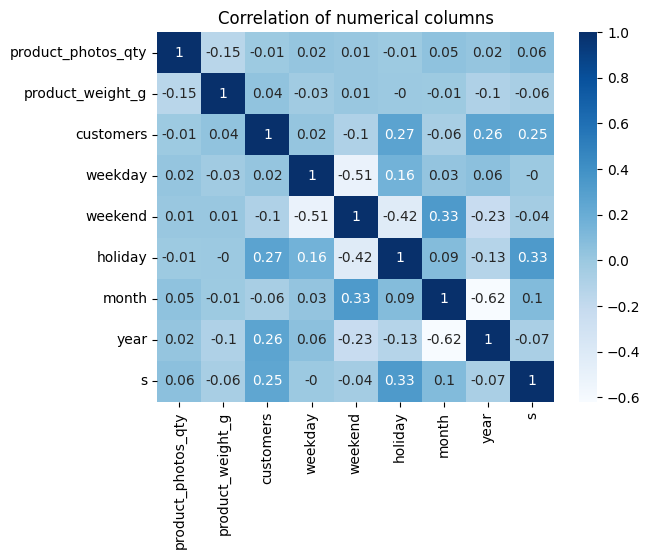

In [20]:
sns.heatmap(df[set1].corr().round(2),annot=True,cmap='Blues')
plt.title('Correlation of numerical columns')
plt.show()

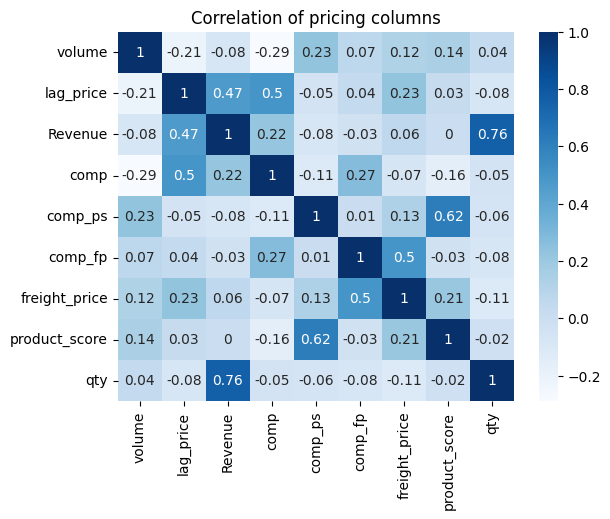

In [21]:
sns.heatmap(df[set2].corr().round(2),annot=True,cmap='Blues')
plt.title('Correlation of pricing columns')
plt.show()

### `lag_price` is mildly positively correlated `Revenue`, `Comp` and `total_price`.

### `product_score` is positively correlated with `comp_ps`.

## Univariate Analysis

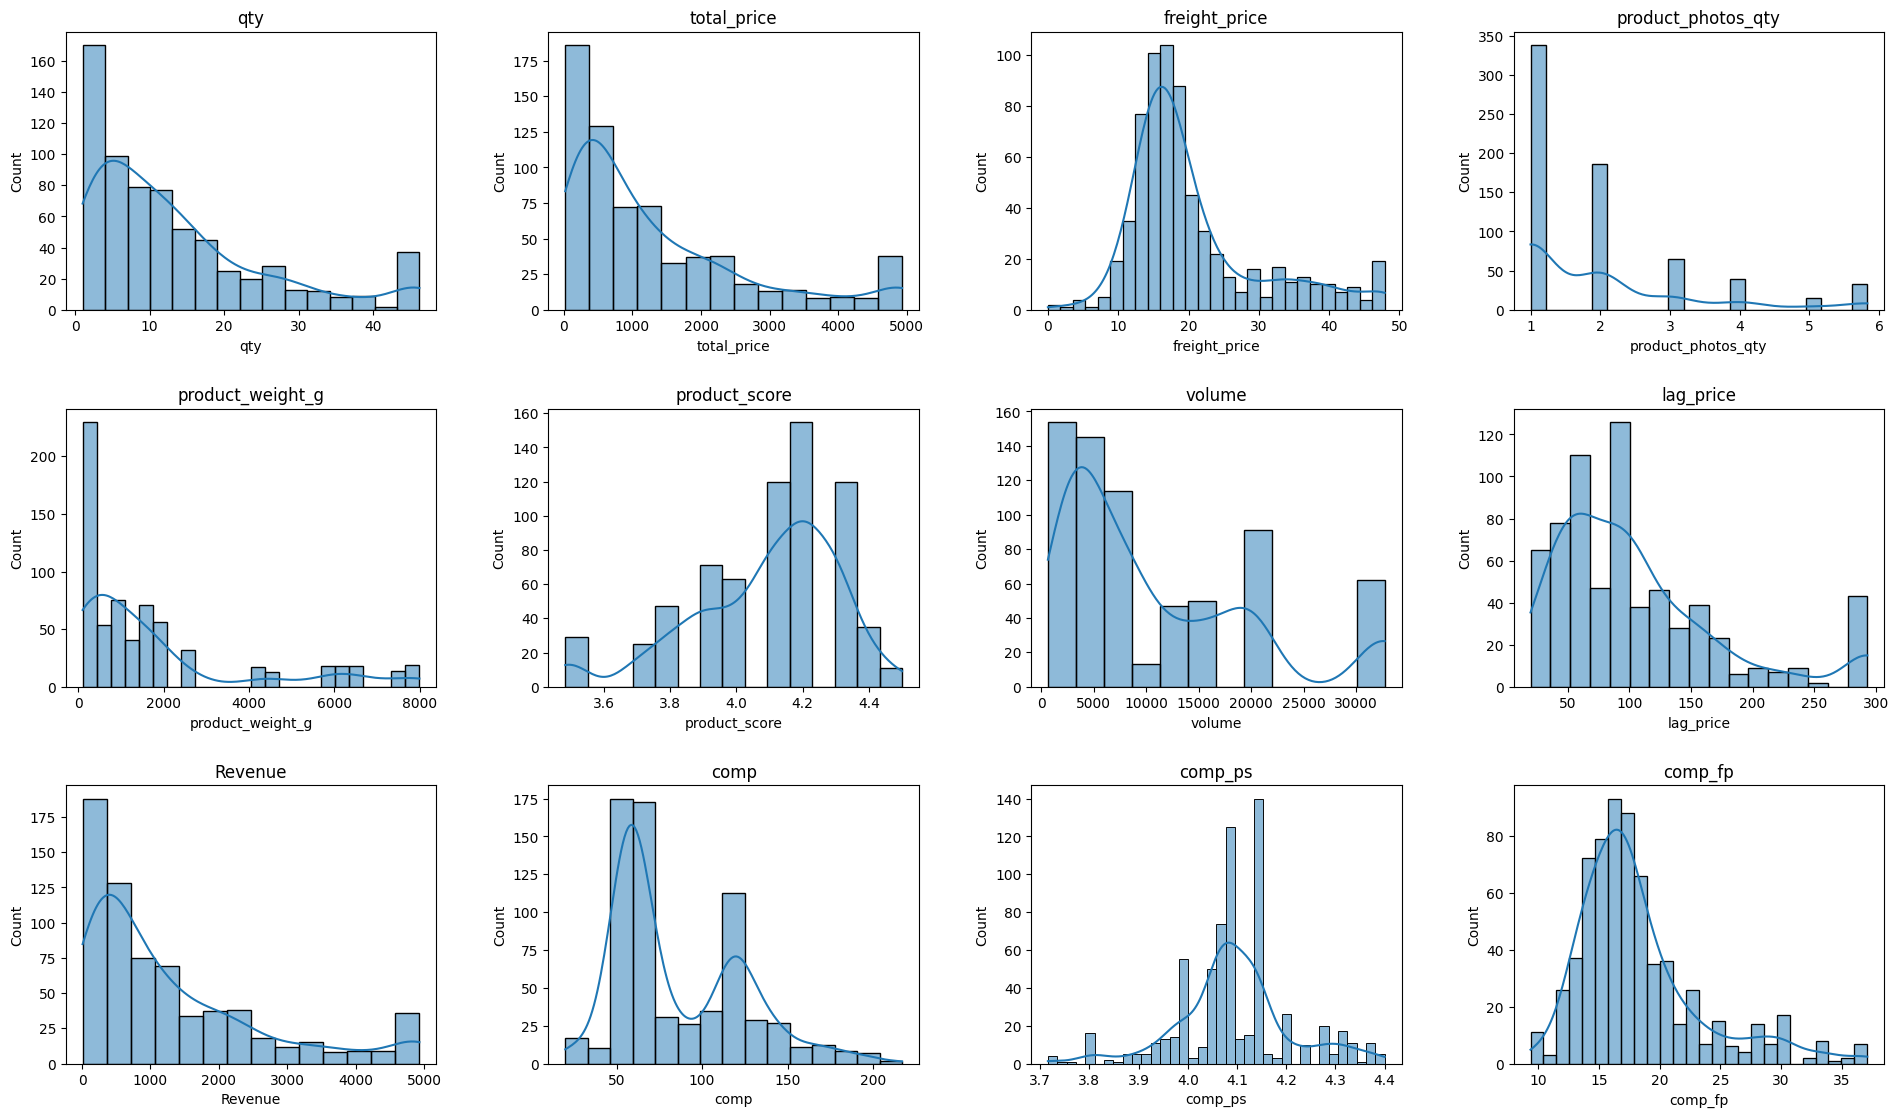

In [22]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.tight_layout(pad=5.0)
axes = axes.flatten()
columns = ['qty', 'total_price', 'freight_price', 'product_photos_qty',
           'product_weight_g', 'product_score', 'volume', 'lag_price', 'Revenue',
           'comp', 'comp_ps', 'comp_fp']
for i, col in enumerate(columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
for i in range(len(columns), len(axes)):
    axes[i].axis('off')
plt.show()

## Pairplot for important numerical columns

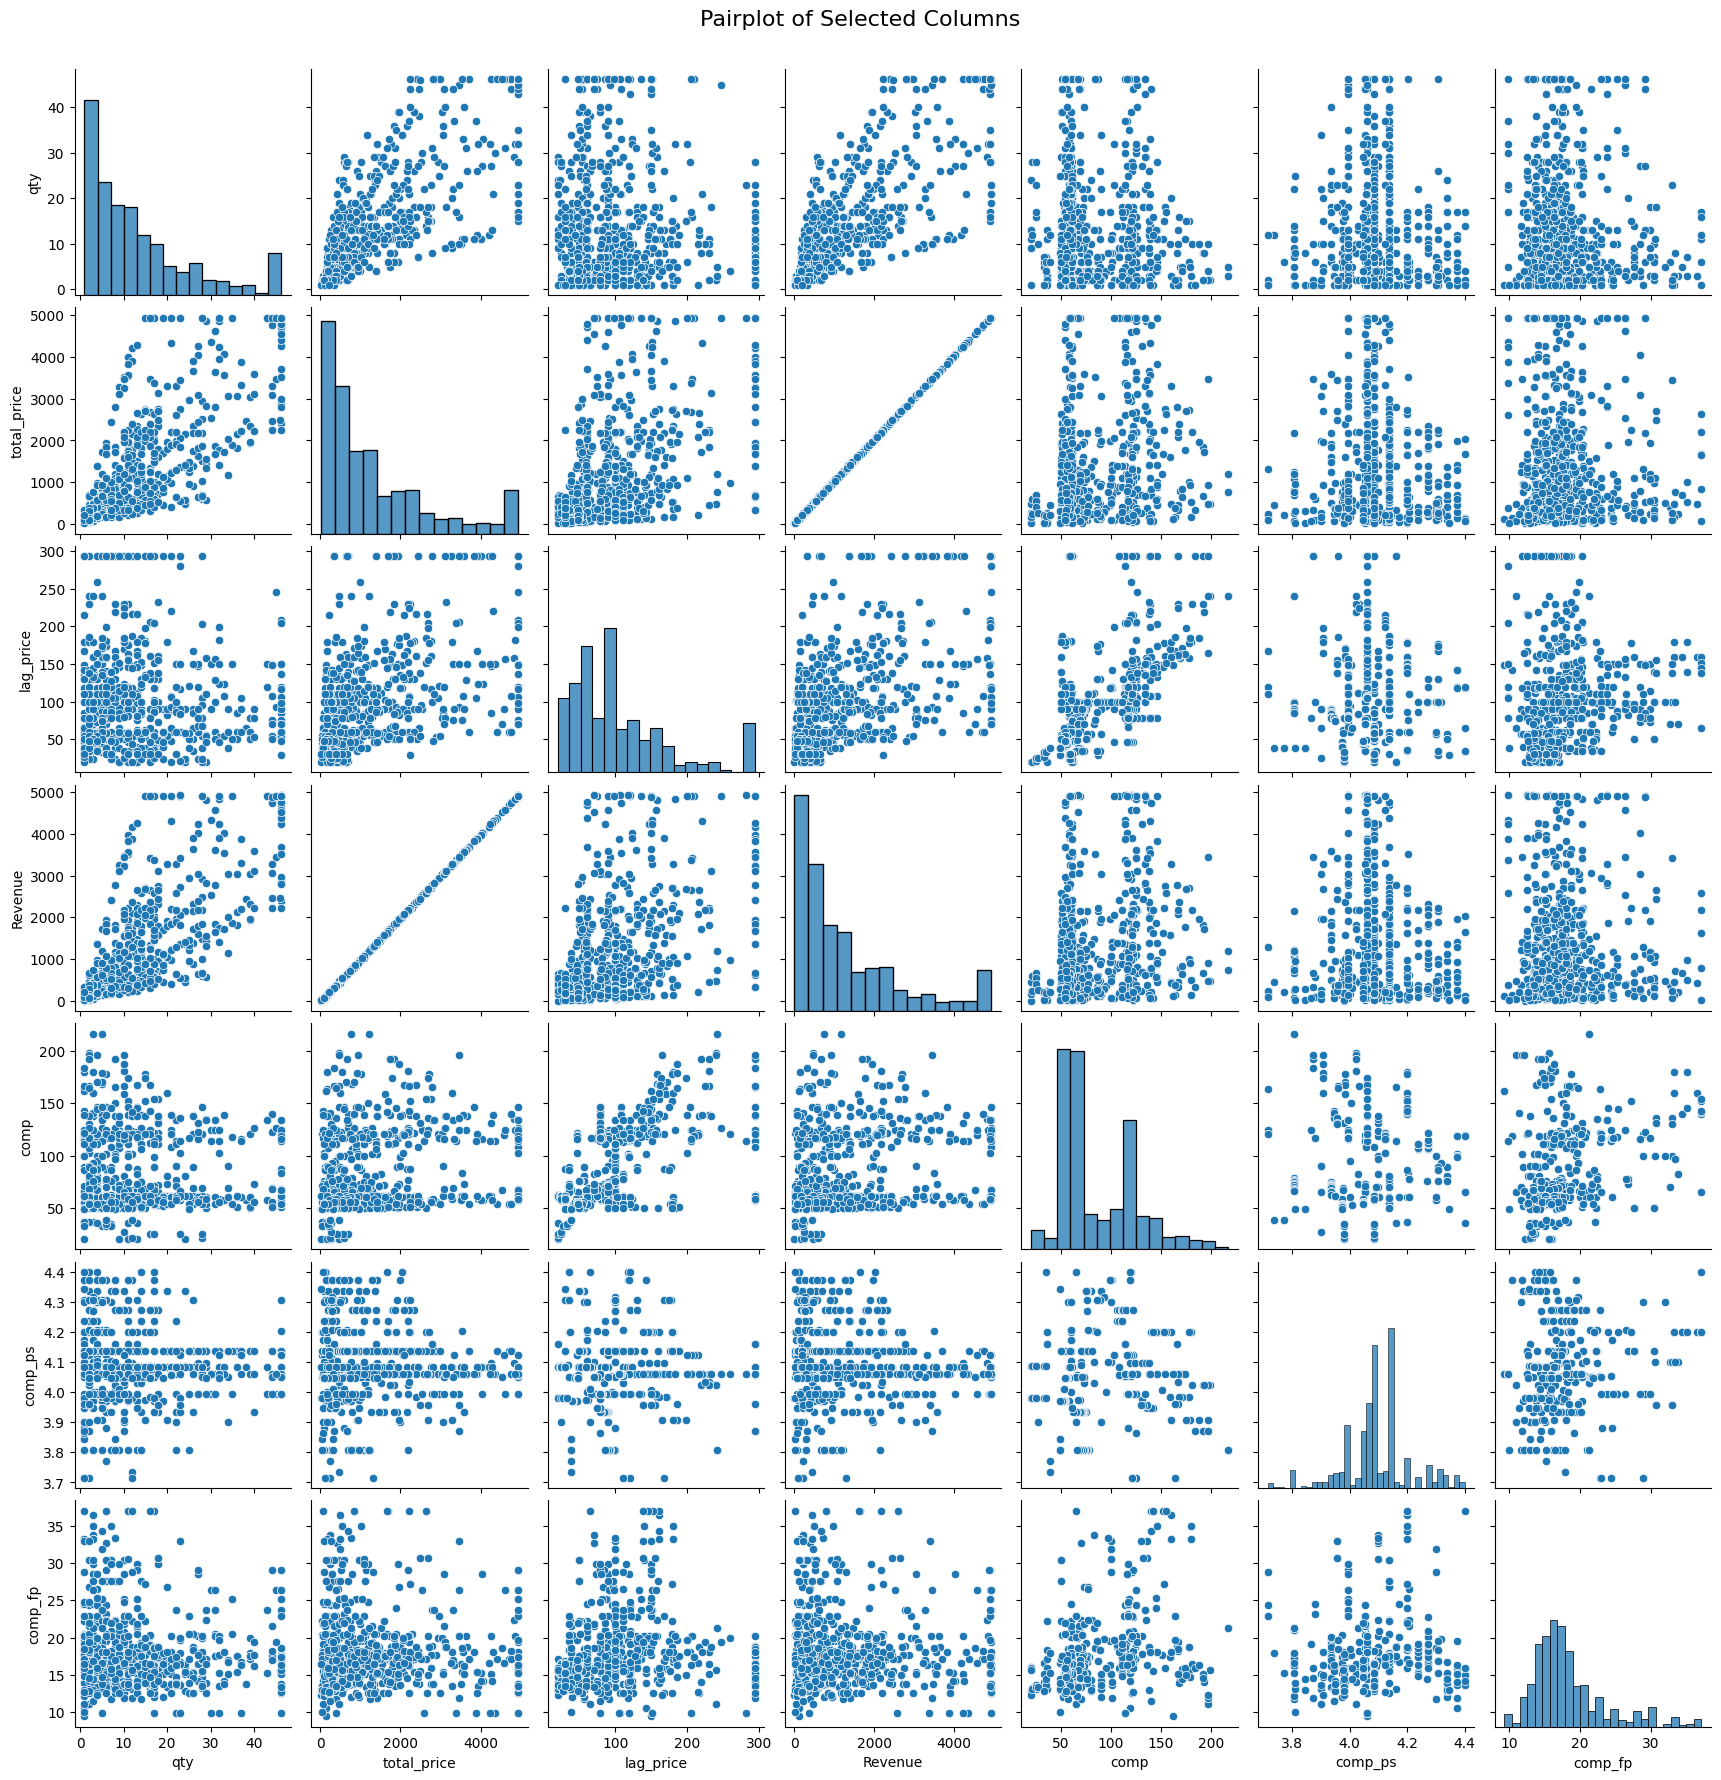

In [23]:
columns = ['qty', 'total_price', 'lag_price', 'Revenue', 'comp', 'comp_ps', 'comp_fp']
pairplot = sns.pairplot(df[columns])
plt.suptitle('Pairplot of Selected Columns', y=1.02, fontsize=16)
plt.show()

## Temporal Analysis

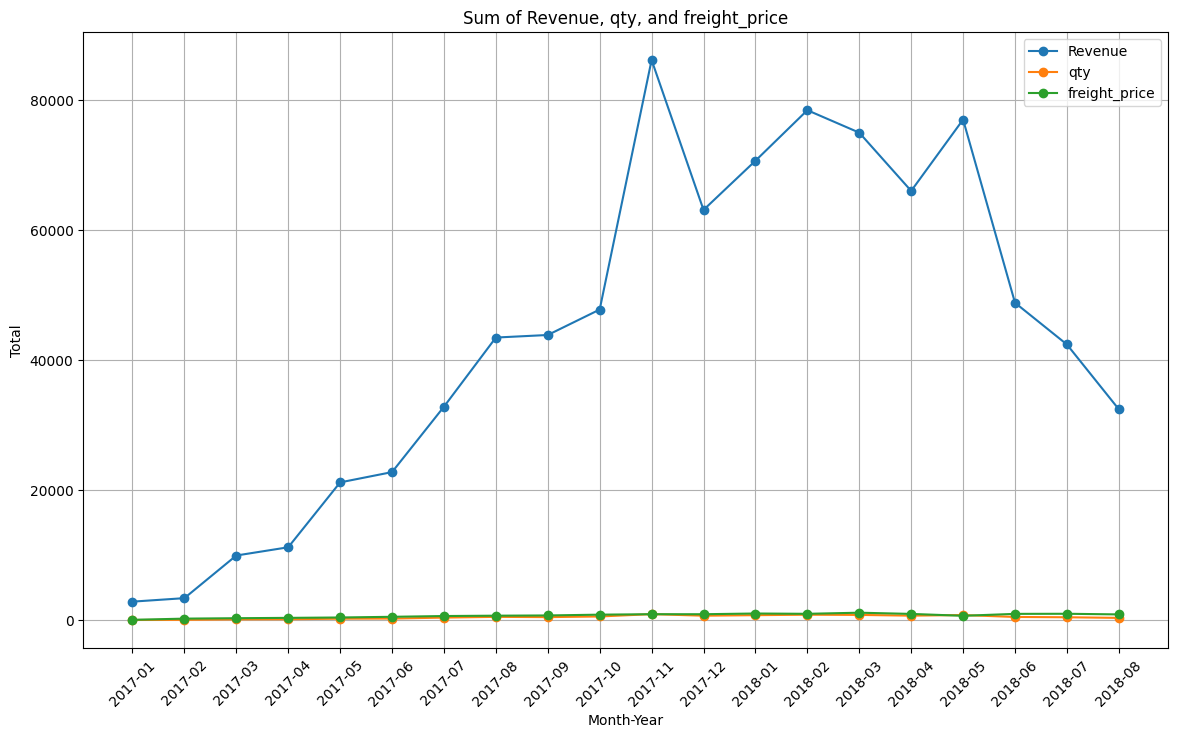

In [24]:
monthly_summary = df.groupby(['year', 'month'])[['Revenue', 'qty', 'freight_price']].sum().reset_index()
monthly_summary['month_year'] = monthly_summary['year'].astype(str) + '-' + monthly_summary['month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 8))
for column in ['Revenue', 'qty', 'freight_price']:
    plt.plot(monthly_summary['month_year'], monthly_summary[column], marker='o', label=column)

plt.title('Sum of Revenue, qty, and freight_price')
plt.xlabel('Month-Year')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.legend()
plt.grid(visible=True)
plt.show()

### `Revenue` peaked in 2017-11, `freight_price` and `qty` more or less stays same throughout.

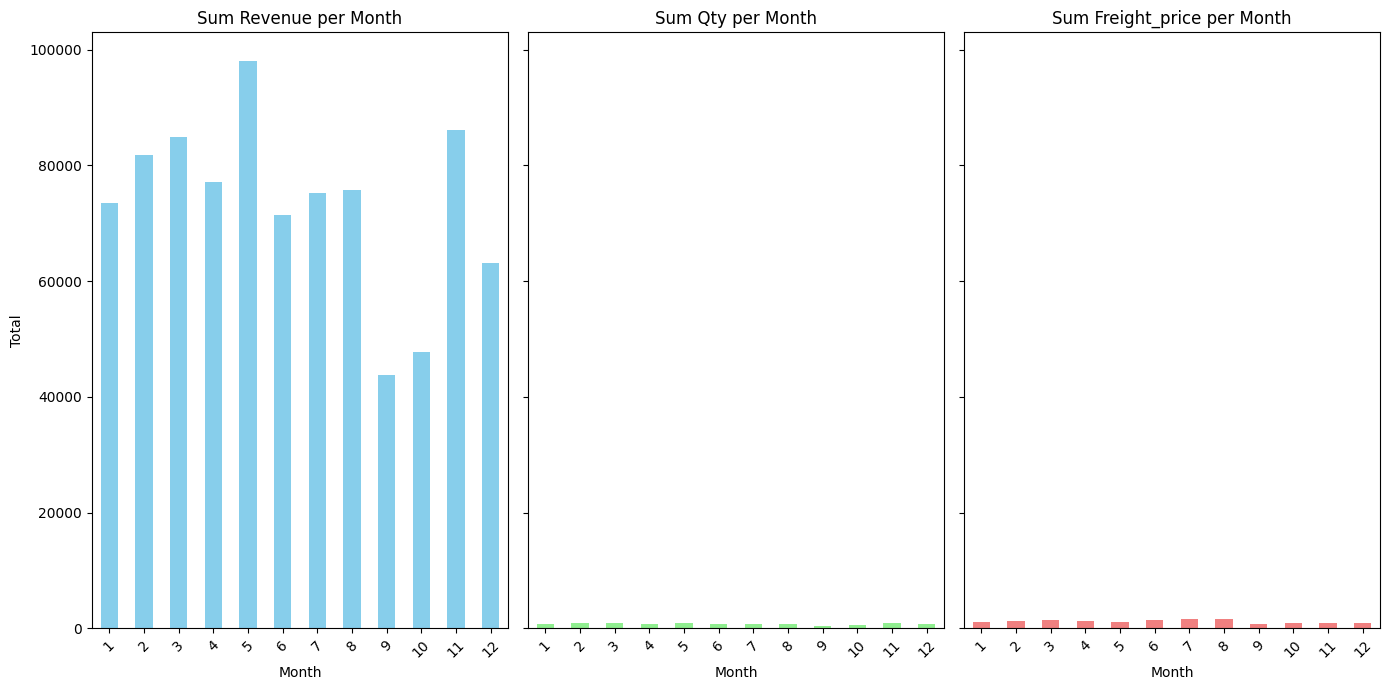

In [25]:
monthly_means = df.groupby('month')[['Revenue', 'qty', 'freight_price']].sum()

fig, axes = plt.subplots(1, 3, figsize=(14, 7), sharey=True)

colors = ['skyblue', 'lightgreen', 'lightcoral']
columns = ['Revenue', 'qty', 'freight_price']

for i, col in enumerate(columns):
    monthly_means[col].plot(kind='bar', stacked=True, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Sum {col.capitalize()} per Month')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Total')
    axes[i].set_xticks(range(0, 12))
    axes[i].set_xticklabels(monthly_means.index, rotation=45)

plt.tight_layout()
plt.show()

### `May` gives most revenue followed by `November` then `March`.

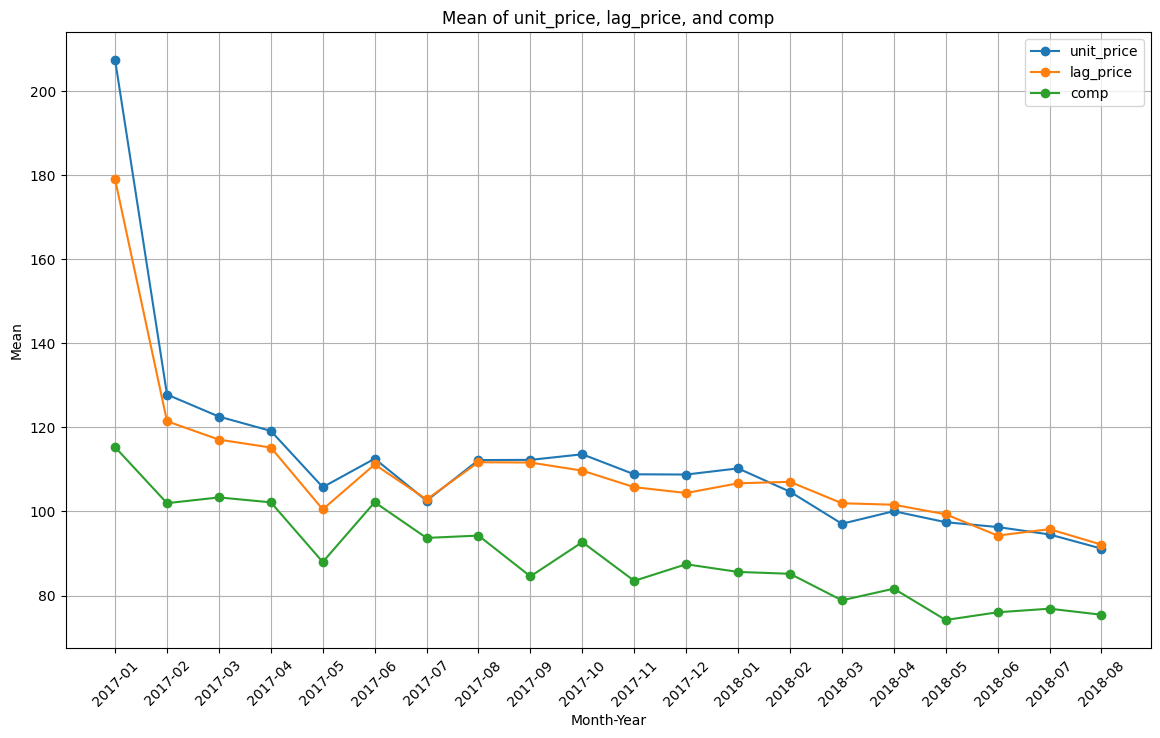

In [26]:
df_=df.copy()
df_['unit_price']=df_.total_price/df_.qty
monthly_summary = df_.groupby(['year', 'month'])[['unit_price', 'lag_price', 'comp']].mean().reset_index()
monthly_summary['month_year'] = monthly_summary['year'].astype(str) + '-' + monthly_summary['month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 8))
for column in ['unit_price', 'lag_price', 'comp']:
    plt.plot(monthly_summary['month_year'], monthly_summary[column], marker='o', label=column)

plt.title('Mean of unit_price, lag_price, and comp')
plt.xlabel('Month-Year')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.legend()
plt.grid(visible=True)
plt.show()

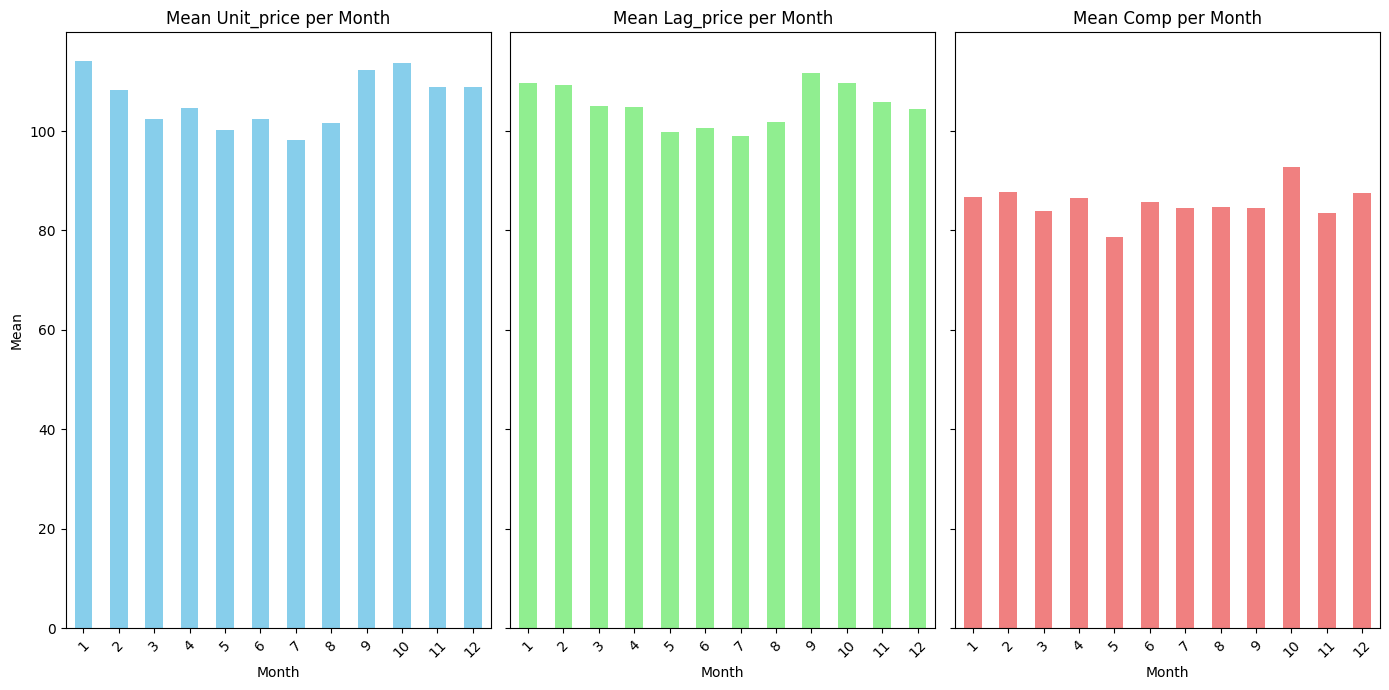

In [27]:
df_=df.copy()
df_['unit_price']=df_.total_price/df_.qty
monthly_means = df_.groupby('month')[['unit_price', 'lag_price', 'comp']].mean()

fig, axes = plt.subplots(1, 3, figsize=(14, 7), sharey=True)

colors = ['skyblue', 'lightgreen', 'lightcoral']
columns = ['unit_price', 'lag_price', 'comp']

for i, col in enumerate(columns):
    monthly_means[col].plot(kind='bar', stacked=True, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Mean {col.capitalize()} per Month')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Mean')
    axes[i].set_xticks(range(0, 12))
    axes[i].set_xticklabels(monthly_means.index, rotation=45)

plt.tight_layout()
plt.show()

### `unit_price` is always higher than `comp` price more closer to `lag_price` maybe more discounts can be given to attract more customers.

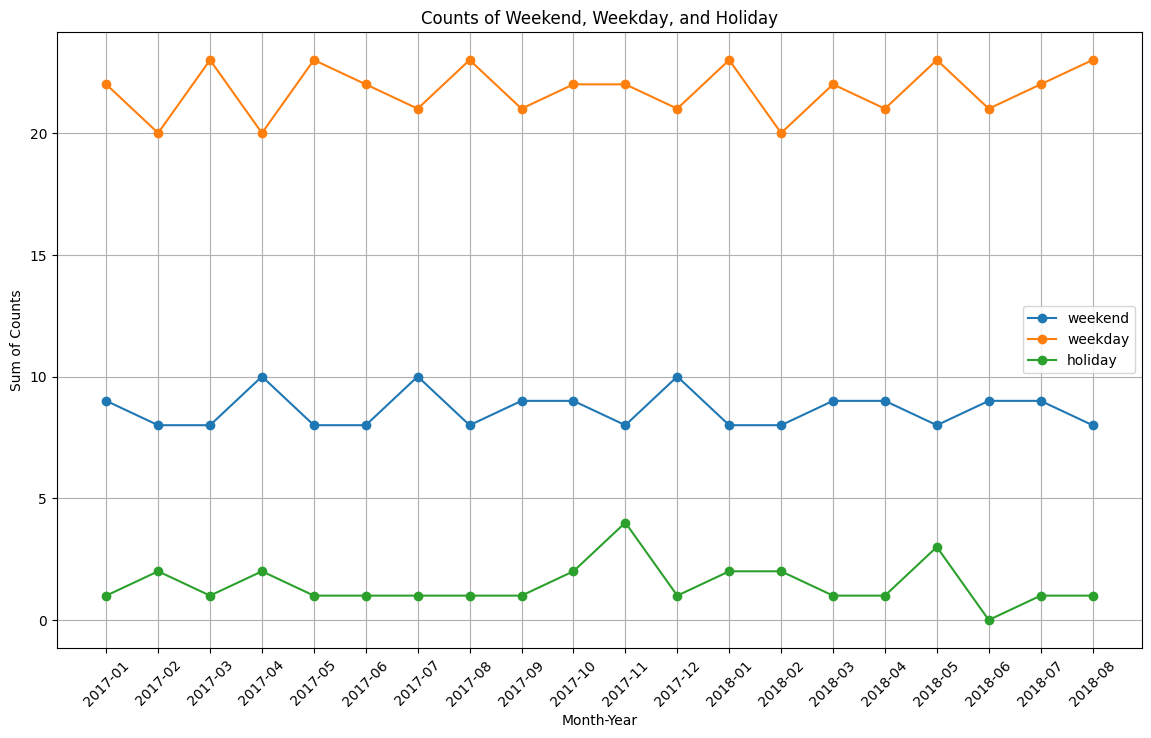

In [28]:
monthly_summary = df.groupby(['year', 'month'])[['weekend', 'weekday', 'holiday']].mean().reset_index()
monthly_summary['month_year'] = monthly_summary['year'].astype(str) + '-' + monthly_summary['month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 8))
for column in ['weekend', 'weekday', 'holiday']:
    plt.plot(monthly_summary['month_year'], monthly_summary[column], marker='o', label=column)

plt.title('Counts of Weekend, Weekday, and Holiday')
plt.xlabel('Month-Year')
plt.ylabel('Sum of Counts')
plt.xticks(rotation=45)
plt.legend()
plt.grid(visible=True)
plt.show()

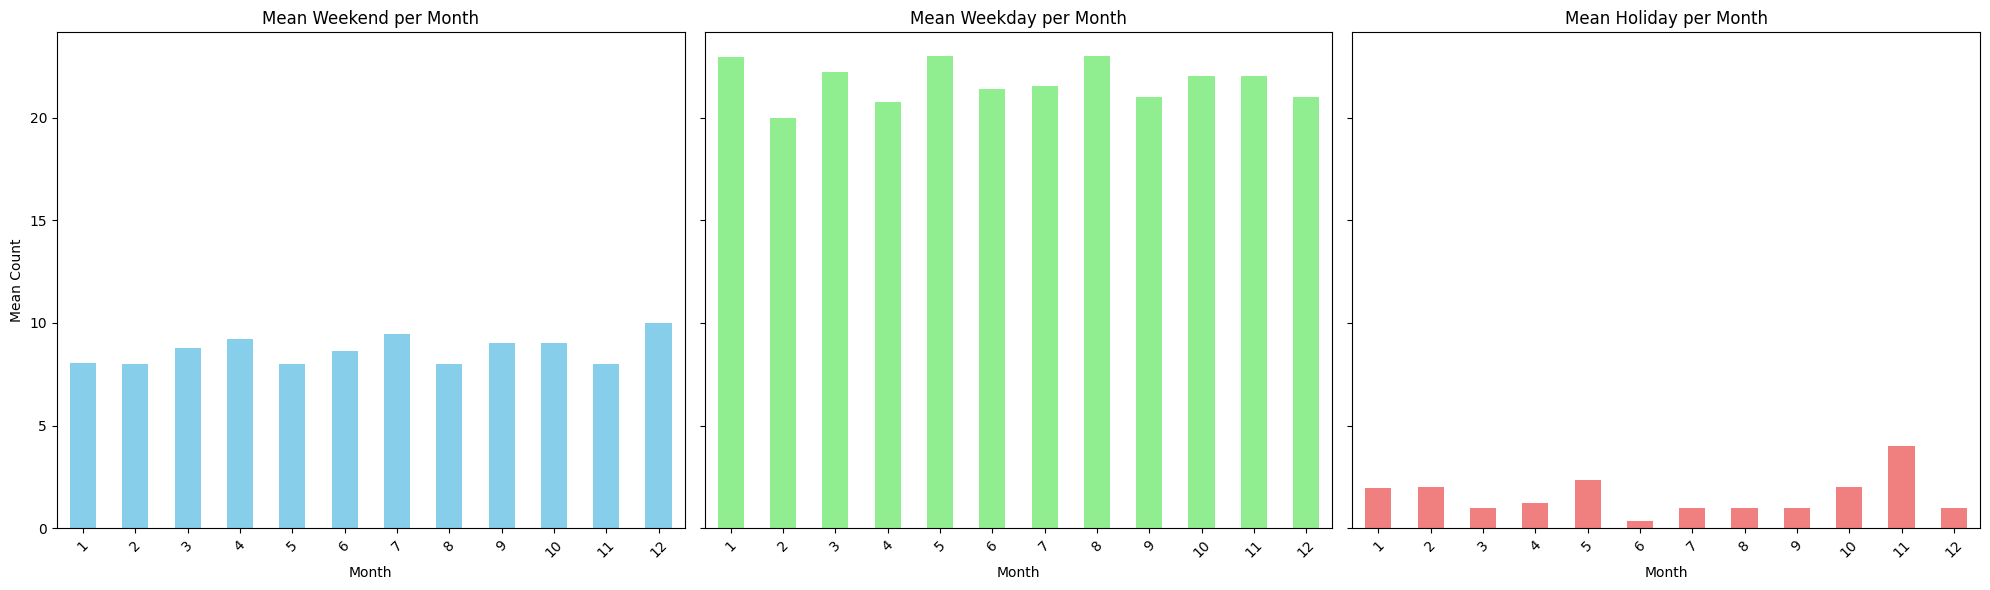

In [29]:
monthly_means = df.groupby('month')[['weekend', 'weekday', 'holiday']].mean()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

colors = ['skyblue', 'lightgreen', 'lightcoral']
columns = ['weekend', 'weekday', 'holiday']

for i, col in enumerate(columns):
    monthly_means[col].plot(kind='bar', stacked=True, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Mean {col.capitalize()} per Month')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Mean Count')
    axes[i].set_xticks(range(0, 12))
    axes[i].set_xticklabels(monthly_means.index, rotation=45)

plt.tight_layout()
plt.show()

### Not much difference between mean `weekday` , `weekend` and `holiday` counts for year-month as well as month levels.

## Popular product categories

+----+-----------------------+-------------------+
|    | Product Category      |   Total Customers |
+====+=======================+===================+
|  0 | garden_tools          |          16713.8  |
+----+-----------------------+-------------------+
|  1 | health_beauty         |          13765    |
+----+-----------------------+-------------------+
|  2 | watches_gifts         |           9651.62 |
+----+-----------------------+-------------------+
|  3 | computers_accessories |           4807    |
+----+-----------------------+-------------------+
|  4 | bed_bath_table        |           3313    |
+----+-----------------------+-------------------+
|  5 | furniture_decor       |           2495    |
+----+-----------------------+-------------------+
|  6 | cool_stuff            |           2168    |
+----+-----------------------+-------------------+
|  7 | consoles_games        |            439    |
+----+-----------------------+-------------------+
|  8 | perfumery             | 

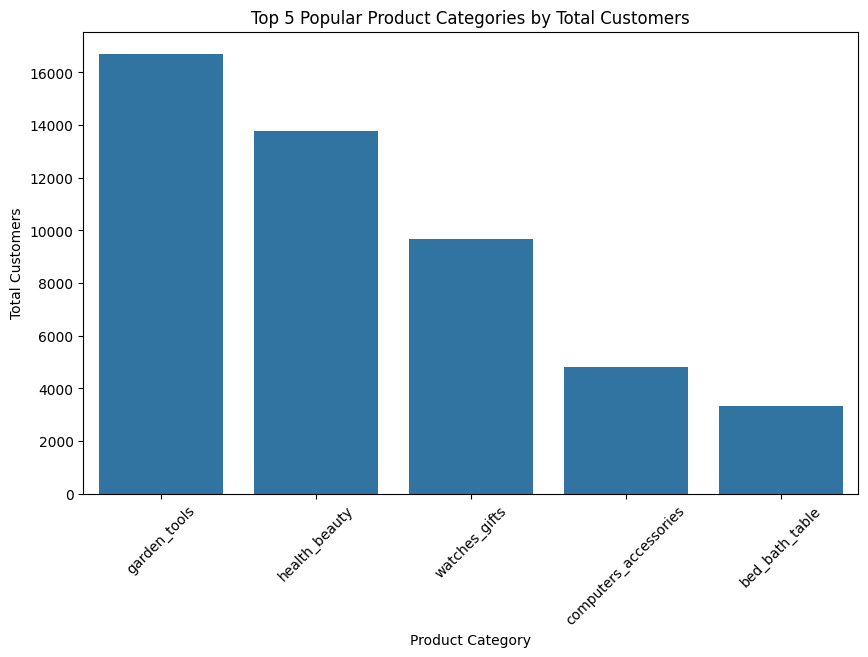

In [30]:
category_summary = df.groupby('product_category_name')['customers'].sum().sort_values(ascending=False)
print(tabulate(category_summary.reset_index(), headers=['Product Category', 'Total Customers'], tablefmt='grid'))

category_summary=category_summary.head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_summary.index, y=category_summary.values)
plt.title('Top 5 Popular Product Categories by Total Customers')
plt.xlabel('Product Category')
plt.ylabel('Total Customers')
plt.xticks(rotation=45)
plt.show()

+----+-----------------------+-----------------+
|    | Product Category      |   Total Revenue |
+====+=======================+=================+
|  0 | health_beauty         |       193556    |
+----+-----------------------+-----------------+
|  1 | watches_gifts         |       189858    |
+----+-----------------------+-----------------+
|  2 | garden_tools          |       159146    |
+----+-----------------------+-----------------+
|  3 | computers_accessories |       123182    |
+----+-----------------------+-----------------+
|  4 | bed_bath_table        |        80450.3  |
+----+-----------------------+-----------------+
|  5 | cool_stuff            |        56884    |
+----+-----------------------+-----------------+
|  6 | furniture_decor       |        50131.8  |
+----+-----------------------+-----------------+
|  7 | perfumery             |        19939.8  |
+----+-----------------------+-----------------+
|  8 | consoles_games        |         5474.89 |
+----+--------------

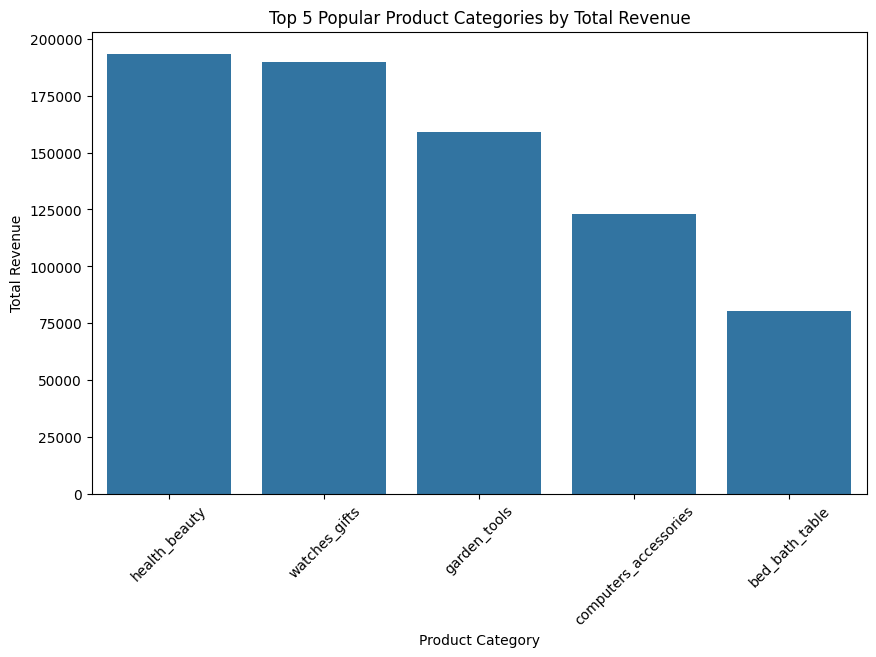

In [31]:
category_summary = df.groupby('product_category_name')['Revenue'].sum().sort_values(ascending=False)
print(tabulate(category_summary.reset_index(), headers=['Product Category', 'Total Revenue'], tablefmt='grid'))

category_summary=category_summary.head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_summary.index, y=category_summary.values)
plt.title('Top 5 Popular Product Categories by Total Revenue')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

`health_beauty`, `watches_gifts` and `garden_tools` are the categories that are very important.

## Boxplots of important numerical columns by `product_category_name` and `product_id`

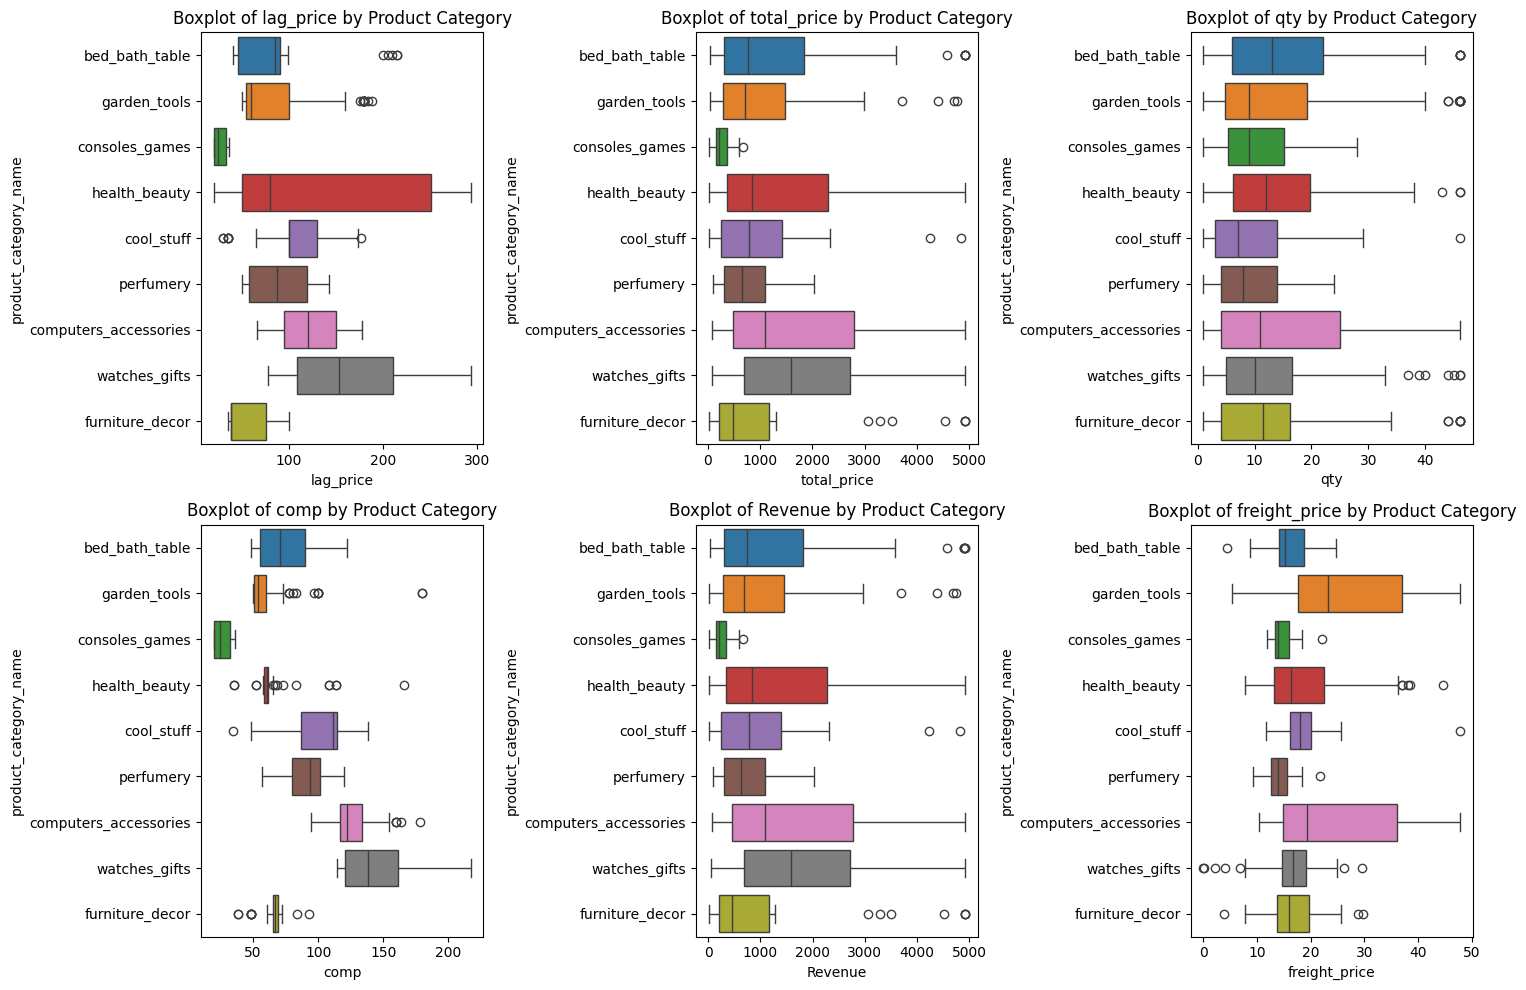

In [32]:
imp_cols = ['lag_price', 'total_price', 'qty', 'comp', 'Revenue', 'freight_price']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(imp_cols):
    sns.boxplot(y='product_category_name', x=col, hue='product_category_name', data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Product Category')

plt.tight_layout()
plt.show()

### `health_beauty` , `computer_accessories` and `watches_gifts` are important categories.

## Popular product_id s

+----+--------------+-------------------+
|    | Product_id   |   Total Customers |
+====+==============+===================+
|  0 | health5      |           1775    |
+----+--------------+-------------------+
|  1 | health7      |           1775    |
+----+--------------+-------------------+
|  2 | garden1      |           1748.58 |
+----+--------------+-------------------+
|  3 | garden2      |           1741.58 |
+----+--------------+-------------------+
|  4 | garden9      |           1741.58 |
+----+--------------+-------------------+


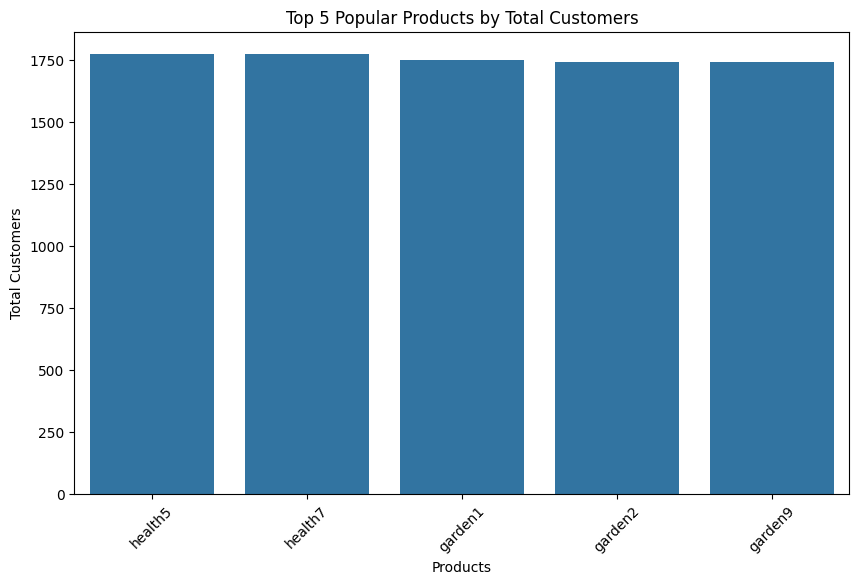

In [33]:
product_summary = df.groupby('product_id')['customers'].sum().sort_values(ascending=False).head()
print(tabulate(product_summary.reset_index(), headers=['Product_id', 'Total Customers'], tablefmt='grid'))

plt.figure(figsize=(10, 6))
sns.barplot(x=product_summary.index, y=product_summary.values)
plt.title('Top 5 Popular Products by Total Customers')
plt.xlabel('Products')
plt.ylabel('Total Customers')
plt.xticks(rotation=45)
plt.show()

+----+--------------+-----------------+
|    | Product_id   |   Total Revenue |
+====+==============+=================+
|  0 | health5      |         52851   |
+----+--------------+-----------------+
|  1 | health2      |         48894.2 |
+----+--------------+-----------------+
|  2 | bed2         |         41866.6 |
+----+--------------+-----------------+
|  3 | computers4   |         41485.9 |
+----+--------------+-----------------+
|  4 | watches1     |         31473.4 |
+----+--------------+-----------------+


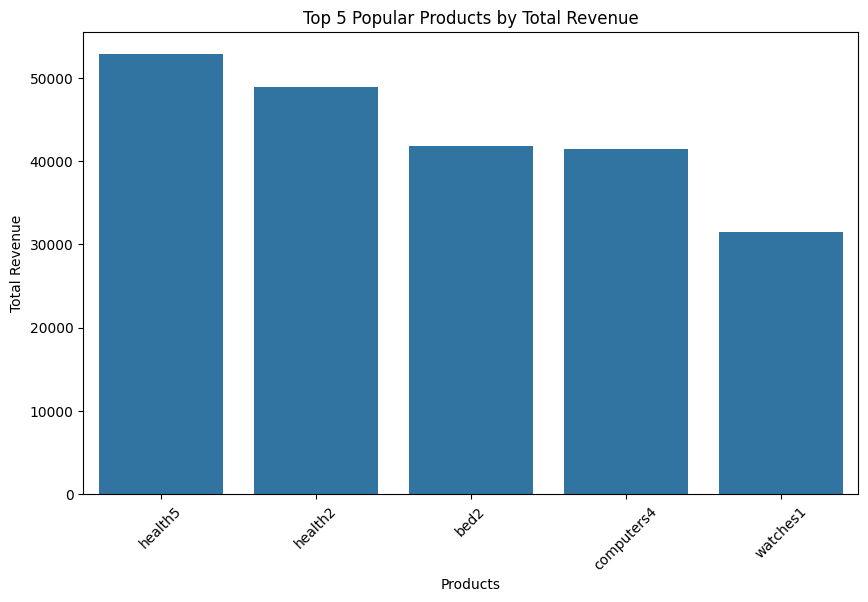

In [34]:
product_summary = df.groupby('product_id')['Revenue'].sum().sort_values(ascending=False).head(5)
print(tabulate(product_summary.reset_index(), headers=['Product_id', 'Total Revenue'], tablefmt='grid'))

plt.figure(figsize=(10, 6))
sns.barplot(x=product_summary.index, y=product_summary.values)
plt.title('Top 5 Popular Products by Total Revenue')
plt.xlabel('Products')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

### Popular products like `health5`, `health2` , `bed2` and `health7` should be focused on to increase revenue.

# Time Series predicting `Revenue` per `product_id` using prophet library

In [35]:
df.month_year=pd.to_datetime(df.month_year)
def forecast_Revenue(df, product_id, periods):
  df_=df[df.product_id==product_id]
  df_ = df_[['month_year', 'Revenue']].rename(columns={'month_year':'ds', 'Revenue':'y'})
  m = Prophet()
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  m.fit(df_)
  future = m.make_future_dataframe(periods=periods)
  forecast = m.predict(future)
  return m, forecast

In [36]:
model,forecast = forecast_Revenue(df,'bed1',365)
plot_plotly(model, forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp115f43gi/7666l61q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp115f43gi/e1gw53c5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29354', 'data', 'file=/tmp/tmp115f43gi/7666l61q.json', 'init=/tmp/tmp115f43gi/e1gw53c5.json', 'output', 'file=/tmp/tmp115f43gi/prophet_modele9g0y5qq/prophet_model-20241121035149.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:51:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:

## Similarly we can get prediction of `Revenue` or other required columns for all `product_id`s and plan accordingly.

## Using Regression method to predict the `total_price` and `qty' and `unit_price`

In [37]:
df=df.drop(columns=['month_year'])

In [38]:
df.columns

Index(['product_id', 'product_category_name', 'qty', 'total_price',
       'freight_price', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'lag_price', 'Revenue', 'comp', 'comp_ps',
       'comp_fp'],
      dtype='object')

In [39]:
le = LabelEncoder()
df.product_id=le.fit_transform(df.product_id)
df.product_category_name=le.fit_transform(df.product_category_name)

In [40]:
all=df.copy()
df.head()

,product_id,product_category_name,qty,total_price,freight_price,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,lag_price,Revenue,comp,comp_ps,comp_fp
0,0,0,1.0,45.95,15.100000,2.0,350.0,4.0,57.0,23,8,1,5,2017,10.267394,3800,45.90,30.850000,122.099156,4.124377,12.670932
1,0,0,3.0,137.85,12.933333,2.0,350.0,4.0,61.0,22,8,1,6,2017,6.503115,3800,45.95,124.916667,119.823163,4.124377,16.617652
2,0,0,6.0,275.70,14.840000,2.0,350.0,4.0,123.0,21,10,1,7,2017,12.071651,3800,45.95,260.860000,118.305834,4.124377,17.398863
3,0,0,4.0,183.80,14.287500,2.0,350.0,4.0,90.0,23,8,1,8,2017,9.293873,3800,45.95,169.512500,116.223226,4.124377,16.332738
4,0,0,2.0,91.90,15.100000,2.0,350.0,4.0,54.0,21,9,1,9,2017,5.555556,3800,45.95,76.800000,102.525124,4.124377,19.604977


In [ ]:
X,y=all.drop(columns=['qty','total_price']),all['qty']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=95, stratify=all.product_id)
param_distributions = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': [3, 5, 10, 20, 50, None],
    'learning_rate': np.arange(.1, 1, .1),
    'gamma': np.arange(0, 1, .2),
    'subsample': np.arange(.5, 1, .1),
    'colsample_bytree': np.arange(.5, 1, .1),
    'reg_alpha': np.arange(0, 1, .2),
    'reg_lambda': np.arange(0, 1, .2)
}
xgb_model=XGBRegressor(random_state=95)
rs=RandomizedSearchCV(estimator=xgb_model,
                       param_distributions=param_distributions,
                       cv=4, n_iter=100, random_state=95,
                       scoring='f1_macro')


rs.fit(X_train,y_train)
recognizer=rs.best_estimator_
print(rs.best_params_)
print(f'R^2 score for quantity is {recognizer.score(X_test,y_test)}')
print(f'Rmse for quantity is {np.sqrt(mse(recognizer.predict(X_test),y_test))}')

In [ ]:
X,y=all.drop(columns=['total_price','qty']),all['total_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=95, stratify=all.product_id)
param_distributions = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': [3, 5, 10, 20, 50, None],
    'learning_rate': np.arange(.1, 1, .1),
    'gamma': np.arange(0, 1, .2),
    'subsample': np.arange(.5, 1, .1),
    'colsample_bytree': np.arange(.5, 1, .1),
    'reg_alpha': np.arange(0, 1, .2),
    'reg_lambda': np.arange(0, 1, .2)
}
xgb_model=XGBRegressor(random_state=95)
rs=RandomizedSearchCV(estimator=xgb_model,
                       param_distributions=param_distributions,
                       cv=4, n_iter=100, random_state=95,
                       scoring='f1_macro')


rs.fit(X_train,y_train)
recognizer=rs.best_estimator_
print(rs.best_params_)
print(f'R^2 score for total_price is {recognizer.score(X_test,y_test)}')
print(f'Rmse for total_price is {np.sqrt(mse(recognizer.predict(X_test),y_test))}')

In [ ]:
X,y=all.drop(columns=['total_price','qty']),all['total_price']/all['qty']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=95, stratify=all.product_id)
param_distributions = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': [3, 5, 10, 20, 50, None],
    'learning_rate': np.arange(.1, 1, .1),
    'gamma': np.arange(0, 1, .2),
    'subsample': np.arange(.5, 1, .1),
    'colsample_bytree': np.arange(.5, 1, .1),
    'reg_alpha': np.arange(0, 1, .2),
    'reg_lambda': np.arange(0, 1, .2)
}
xgb_model=XGBRegressor(random_state=95)
rs=RandomizedSearchCV(estimator=xgb_model,
                       param_distributions=param_distributions,
                       cv=4, n_iter=100, random_state=95,
                       scoring='f1_macro')


rs.fit(X_train,y_train)
recognizer=rs.best_estimator_
print(rs.best_params_)
print(f'R^2 score for unit_price is {recognizer.score(X_test,y_test)}')
print(f'Rmse for unit_price is {np.sqrt(mse(recognizer.predict(X_test),y_test))}')

In [ ]:
plot_importance(recognizer)
plt.title('Feature importance ')
plt.show()

### Use the models to predict prices and quantities based on the different parameters, the R^2 score is good so we can trust the models, also we can compare with some other baseline.

# Insights and Recommendations

- **Correlations**:
  - Freight price is positively correlated with weight.
  - Total price shows a positive correlation with quantity.
  - Weekday and weekend are negatively correlated.
  - `lag_price` shows mild positive correlation with revenue, competition (`Comp`), and `total_price`.
  - `product_score` is positively correlated with `comp_ps`.

- **Trends and Patterns**:
  - Revenue peaked in **November 2017**, while `freight_price` and `qty` remained stable over time.
  - `unit_price` is consistently higher than competitor prices and is closer to `lag_price`, suggesting room for more competitive pricing (e.g., offering discounts).

- **Comparative Analysis**:
  - No significant differences in mean counts between weekdays, weekends, and holidays at the `year-month` or `month` levels.

- **Important Categories**:
  - **health_beauty**, **watches_gifts**, and **garden_tools** are key product categories for revenue focus.
  - High-revenue products like **health5**, **health2**, **bed2**, and **health7** should be prioritized to drive further sales.

### Model Performance and Recommendations

- **Regression Models** were used to predict `total_price`, `qty`, and `unit_price` with promising results:
  - **Quantity**: R² = 0.89, RMSE = 3.85
  - **Total Price**: R² = 0.998, RMSE = 63.98
  - **Unit Price**: R² = 0.84, RMSE = 28.01



### Recommendations:
1. **Implement targeted discount strategies** for popular products to attract more customers and increase revenue.
2. **Focus marketing efforts** on high-revenue categories and products (e.g., **health_beauty** and products like **health5**).
3. **Monitor competitive pricing** and adjust `unit_price` to stay competitive while maintaining profitability.
4. **Leverage the predictive models** to forecast `total_price`, `qty`, and `unit_price` for various scenarios to plan pricing and inventory effectively.
5. Continue evaluating and refining models against baselines to ensure sustained accuracy and performance.